# B2B analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.dsp        import lowPassFIR, firFilter, pulseShape, decimate, pnorm
from optic.metrics    import fastBERcalc, signal_power, theoryBER
from optic.modulation import modulateGray
from optic.core       import parameters
from optic.models     import awgn, photodiode
from optic.plot       import pconst

from utils.ofdm       import modulateOFDM, demodulateOFDM, Tx, Rx
from commpy.utilities import upsample
from tqdm.notebook    import tqdm
from scipy.signal     import hilbert

pi = np.pi

In [2]:
import scienceplots

plt.style.use('science')
font = {'size':16}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

## Parameters

In [3]:
def calcSymbolRate(M, Rb, Nfft, K, G, hermitSym = True):
    if not hermitSym:
        nDataSymbols = (Nfft-K)
    else:
        nDataSymbols = (Nfft//2 - 1 - K)
    
    return Rb / (nDataSymbols/(Nfft + G) * np.log2(M))

In [4]:
# OFDM
M    = 16                       # Número de símbolos da constelação QAM
Nfft = 512                      # Tamanho da FFT
Ns = int(Nfft/2) - 1            # Número de sub-portadoras
N  = Ns                         # Número de portadoras de informação
Nz = Ns - N                     # Número de subportadoras nulas
G  = 4                          # Tamanho do prefixo cíclico
K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb  = 3e9                       # Taxa de bits/s
Rs  = calcSymbolRate(M, Rb, Nfft, K, G, True)   #Rb*Ns*(1 +G/Nfft) / (np.log2(M)*N)      # Banda do sinal
SpS = 16                         # Amostras por símbolo
Fa  = Rs*SpS                    # Frequência de amostragem
Fc  = 193.4e12                  # Frequência da portadora óptica

In [5]:
# Random bits sequency
bits = np.random.randint(2, size = ((Nfft-K-2)//2)*2**9)

# Maping bits - symbols
symbTx = modulateGray(bits, M, 'qam')
symbTx = pnorm(symbTx) # power normalization

# Pilot carriers
pilot = max(symbTx.real) + 1j*max(symbTx.imag)

# OFDM symbols generation
symbTx_OFDM, symbTx = modulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbTx)

# Upsample + pulse shaping
pulse = pulseShape('rrc', SpS, alpha = 0.2)
pulse = pnorm(pulse)

sigOFDM_Tx = firFilter(pulse, upsample(symbTx_OFDM, SpS))
sigOFDM_Tx = pnorm(sigOFDM_Tx)

In [6]:
Int = int(N/K)
carriers = np.arange(0, N)
pilot_carriers = np.append(carriers[0::Int], carriers[-1])

aux = 0
for i in range(int(len(symbTx)/N)):
    symbTx[aux:aux+N][pilot_carriers] = np.nan
    aux += N

symbTx = symbTx[~np.isnan(symbTx)]

In [7]:
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1

## Parte 1 - OFDM convencional

In [8]:
SNR = np.arange(5, 25)
BER = np.zeros(SNR.shape)
BERth = np.zeros(SNR.shape)
SNRest = np.zeros(SNR.shape)

for kk, runSNR in enumerate(SNR):
    sigOFDM_Rx = awgn(sigOFDM_Tx, runSNR, Fa, Rs)
    sigOFDM_Rx = firFilter(pulse, sigOFDM_Rx)

    sigOFDM_Rx = decimate(sigOFDM_Rx.reshape(-1,1), paramDec)
    sigOFDM_Rx = np.squeeze(sigOFDM_Rx)
    
    # OFDM demodulation
    symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, pnorm(sigOFDM_Rx))

    aux = 0
    for r in range(int(len(symbRx)/N)):
        symbRx[aux:aux+N][pilot_carriers] = np.nan
        aux += N
    symbRx = symbRx[~np.isnan(symbRx)]

    aux = 0
    for r in range(int(len(symbRx_neq)/N)):
        symbRx_neq[aux:aux+N][pilot_carriers] = np.nan
        aux += N
    symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]

    discard = 100
    ind = np.arange(discard,len(symbRx_neq)-discard)
    BER[kk], _, SNRest[kk] = fastBERcalc(symbRx_neq[ind], symbTx[ind], M, 'qam')
    EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
    BERth[kk] = theoryBER(M, EbN0, 'qam')

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


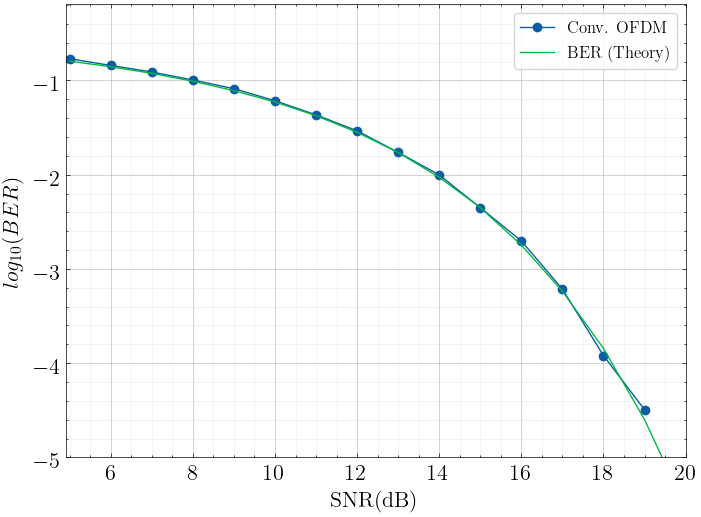

In [9]:
plt.figure(figsize = (8, 6))

plt.plot(SNR, np.log10(BER),'-o', ms= 6, label = f'Conv. OFDM')
plt.plot(SNR, np.log10(BERth),'-', label = 'BER (Theory)')

plt.ylim(-5)
plt.xlim(4.9, 20)
plt.xlabel('SNR(dB)')
plt.ylabel('$log_{10}(BER)$')
plt.legend(fontsize = 12,frameon = True)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

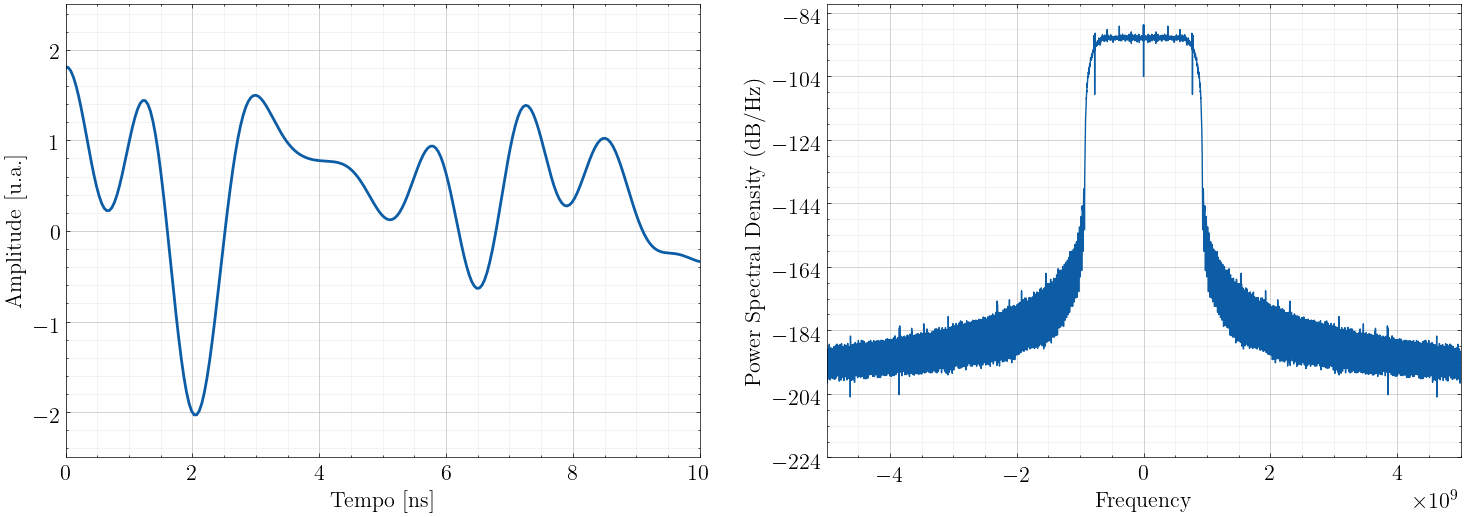

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
idX = np.arange(0, 512)

t = np.arange(0, len(sigOFDM_Tx))*(1/Fa)

ax[0].plot(t[idX]*1e9, (sigOFDM_Tx)[idX].real, lw = 2)
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].set_xlim(0, 10)
ax[0].set_ylim(-2.5, 2.5)
ax[0].grid(which='minor', alpha=0.2)
ax[0].grid(which='major', alpha=0.8)

ax[1].psd(sigOFDM_Tx, Fs = Fa, NFFT = 16*1024, sides='twosided')
ax[1].set_xlim(-5e9, 5e9)
#ax[1].set_ylim(-165)
ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=0.8)

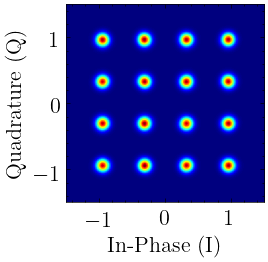

(<Figure size 350x262.5 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b15651fc50>)

In [11]:
pconst(symbRx[ind], pType='fancy', cmap = 'jet')

## Parte 2: CE-OFDM elétrico

  0%|          | 0/4 [00:00<?, ?it/s]

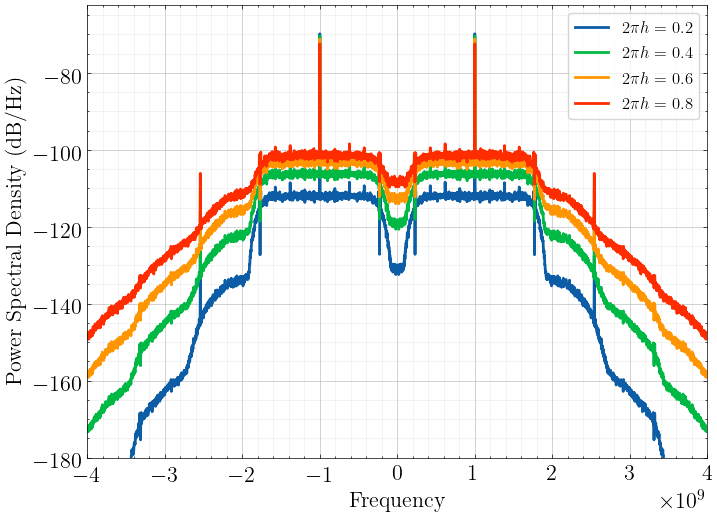

In [12]:
h = np.array([0.2, 0.4, 0.6, 0.8])/(2*pi)
B = np.array([2.5, 2.5, 2.7, 2.9])*1e9

SNR = np.arange(5, 30)
BER = np.zeros((len(h), len(SNR)))
BERth = np.zeros(SNR.shape)
SNRest = np.zeros((len(h), len(SNR)))

fig, ax = plt.subplots(figsize = (8, 6))

for i in tqdm(range(len(h))):
    # CE-OFDM
    H = h[i]
    A = 1
    fc = 1e9
    sigCEOFDM_Tx = A*np.cos(2*pi*fc*t + 2*pi*H*sigOFDM_Tx)
    
    ax.psd(sigCEOFDM_Tx, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"$2\pi h =$ {round(2*pi*h[i],2)}")
    ax.legend(frameon = True)
    ax.set_xlim(-4e9, 4e9)
    ax.legend(frameon = True, fontsize = 12)
    ax.set_ylim(-180)
    
    for kk, runSNR in enumerate(SNR):
        sigOFDM_Rx = awgn(sigCEOFDM_Tx, runSNR, Fa, B[i])

        signal_a = hilbert(sigOFDM_Rx.real) * np.exp(-1j*2*pi*fc*t)
        phase = (np.arctan2(signal_a.imag, signal_a.real))/(2*pi*H)
        
        # Seleção das amostras do sinal recebido 
        phase = firFilter(pulse, phase)
        symbRx_OFDM = decimate(phase.reshape(-1,1), paramDec) # downsampling to 1 sample per symbol
        symbRx_OFDM = np.squeeze(symbRx_OFDM)
        symbRx_OFDM = pnorm(symbRx_OFDM)
        
        # OFDM demodulation
        symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbRx_OFDM)
        
        aux = 0
        for r in range(int(len(symbRx)/N)):
            symbRx[aux:aux+N][pilot_carriers] = np.nan
            aux += N
        symbRx = symbRx[~np.isnan(symbRx)]

        aux = 0
        for r in range(int(len(symbRx_neq)/N)):
            symbRx_neq[aux:aux+N][pilot_carriers] = np.nan
            aux += N
        symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]

        discard = 100
        ind = np.arange(discard,len(symbRx)-discard)
        BER[i, kk], _, SNRest[i, kk] = fastBERcalc(symbRx_neq[ind], symbTx[ind], M, 'qam')
        EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
        BERth[kk] = theoryBER(M, EbN0, 'qam')
           
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


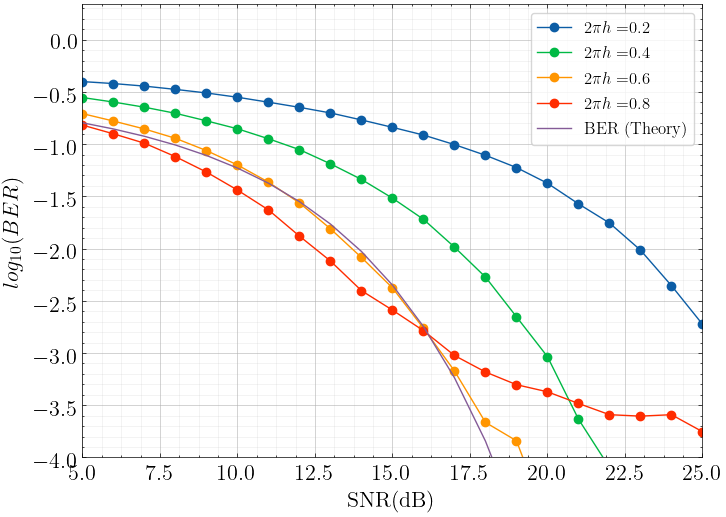

In [13]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(SNR, np.log10(BER[i,:]),'-o', ms= 6, label = f'$2\pi h = ${round(2*pi*h[i], 2)}')

plt.plot(SNR, np.log10(BERth),'-', label = 'BER (Theory)')

plt.ylim(-4)
plt.xlim(5, 25)
plt.xlabel('SNR(dB)')
plt.ylabel('$log_{10}(BER)$')
plt.legend(fontsize = 12,frameon = True)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

## Part 3 - CE-OFDM ideal

  0%|          | 0/4 [00:00<?, ?it/s]

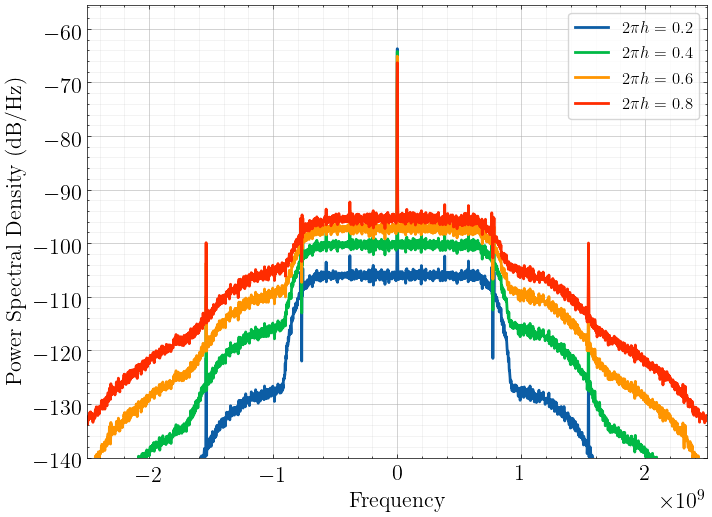

In [14]:
h = np.array([0.2, 0.4, 0.6, 0.8])/(2*pi)
B = np.array([1.1, 1.2, 1.4, 1.6])*Rs

SNR = np.arange(5, 30)
BER = np.zeros((len(h), len(SNR)))
BERth = np.zeros(SNR.shape)
SNRest = np.zeros((len(h), len(SNR)))

fig, ax = plt.subplots(figsize = (8, 6))

for i in tqdm(range(len(h))):
    # CE-OFDM
    H = h[i]
    A = 1
    sigCEOFDM_Tx = A*np.exp(1j*2*pi*H*sigOFDM_Tx)
    
    ax.psd(sigCEOFDM_Tx, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"$2\pi h =$ {round(2*pi*h[i],2)}")
    ax.legend(frameon = True)
    ax.set_xlim(-2.5e9, 2.5e9)
    ax.legend(frameon = True, fontsize = 12)
    ax.set_ylim(-140)
    
    for kk, runSNR in enumerate(SNR):
        sigOFDM_Rx = awgn(sigCEOFDM_Tx, runSNR, Fa, B[i])

        phase = np.arctan2(sigOFDM_Rx.imag, sigOFDM_Rx.real)/(2*pi*H)
        phase = firFilter(pulse, phase)
        
        symbRx_OFDM = decimate(phase.reshape(-1,1), paramDec)
        symbRx_OFDM = pnorm(np.squeeze(symbRx_OFDM))
        
        # OFDM demodulation
        symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbRx_OFDM)
        
        aux = 0
        for r in range(int(len(symbRx)/N)):
            symbRx[aux:aux+N][pilot_carriers] = np.nan
            aux += N
        symbRx = symbRx[~np.isnan(symbRx)]

        aux = 0
        for r in range(int(len(symbRx_neq)/N)):
            symbRx_neq[aux:aux+N][pilot_carriers] = np.nan
            aux += N
        symbRx_neq = symbRx_neq[~np.isnan(symbRx_neq)]

        discard = 100
        ind = np.arange(discard,len(symbRx)-discard)
        BER[i, kk], _, SNRest[i, kk] = fastBERcalc(symbRx_neq[ind], symbTx[ind], M, 'qam')
        EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
        BERth[kk] = theoryBER(M, EbN0, 'qam')
           
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


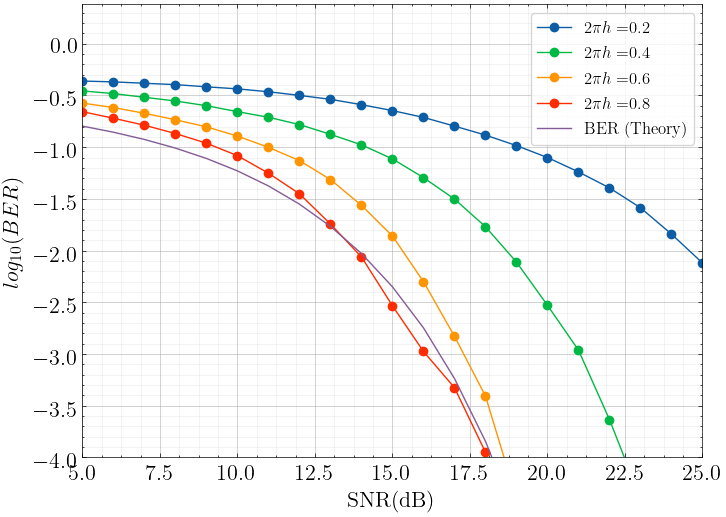

In [15]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(SNR, np.log10(BER[i,:]),'-o', ms= 6, label = f'$2\pi h = ${round(2*pi*h[i], 2)}')

plt.plot(SNR, np.log10(BERth),'-', label = 'BER (Theory)')

plt.ylim(-4)
plt.xlim(5, 25)
plt.xlabel('SNR(dB)')
plt.ylabel('$log_{10}(BER)$')
plt.legend(fontsize = 12,frameon = True)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

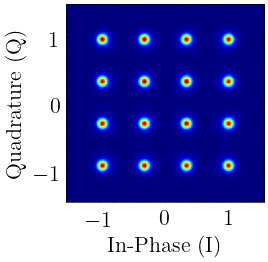

(<Figure size 350x262.5 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fab3d28668>)

In [206]:
pconst(symbRx[ind], pType='fancy', cmap = 'jet')

## Parte 3 - CE-DDO-OFDM e DDO-OFDM

In [46]:
paramTx = parameters()

# Parâmetros do esquema OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

# Parâmetros da transmissão
Rb = 3e9                                # Taxa de bits/s
paramTx.Rs  = calcSymbolRate(paramTx.M, Rb, paramTx.Nfft, paramTx.K, paramTx.G, True)
paramTx.SpS = 16                        # Amostras por símbolo
paramTx.Fa  = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Scheme = "CE-DDO-OFDM"

# Parâmetros da portadora elétrica
paramTx.H  = 0.40/(2*pi)                 # Parâmetro de modulação
paramTx.A  = 2.00                       # Amplitude
paramTx.fc = 1e9                        # Frequência da portadora [Hz]

# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Pi_dBm = 2
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.g = 0.55

Int = int(paramTx.N/paramTx.K)
carriers = np.arange(0, paramTx.N)
pilot_carriers = np.append(carriers[0::Int], carriers[-1])

paramRx = parameters()

# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 1.9e9       # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True     # Definição do modelo: ideal ou real

# Parâmetros do receptor
paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.H   = paramTx.H         # Índice de modulação
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Scheme = paramTx.Scheme

paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [47]:
# Sinal DDO-OFDM
paramTx.Scheme = "DDO-OFDM"

sigTxoDD, sigTxDD, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoDD = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoDD/np.sqrt(signal_power(sigTxoDD))

# Sinal CE-DDO-OFDM
paramTx.Scheme = "CE-DDO-OFDM"

sigTxoCE, sigTxCE, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoCE = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoCE/np.sqrt(signal_power(sigTxoCE))

(-7000000000.0, 7000000000.0)

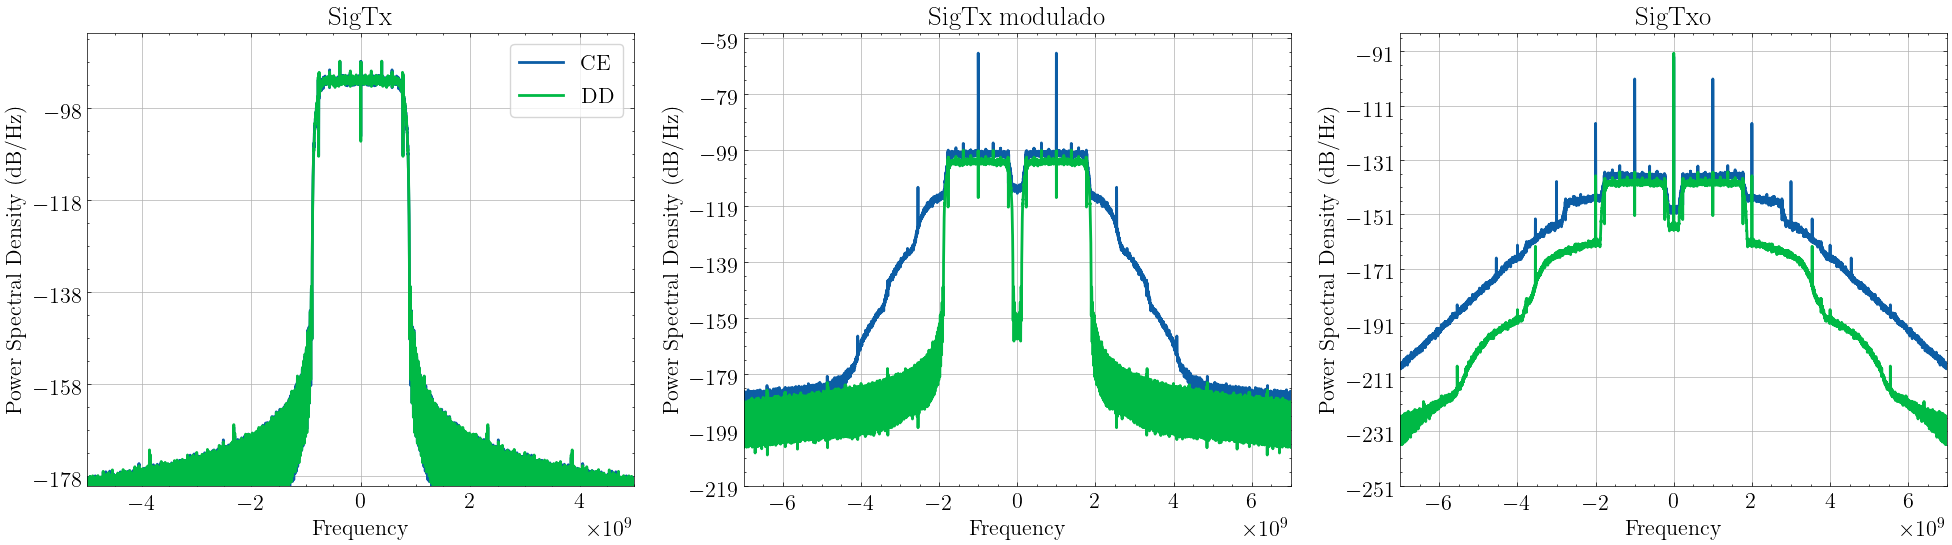

In [48]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))

ax[0].psd(sigTxCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[0].psd(sigTxDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[0].set_title('SigTx')
ax[0].legend(frameon = True)
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[1].psd(sigTx_DD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[1].set_title('SigTx modulado')
ax[1].set_xlim(-7e9, 7e9)
#ax[1].set_ylim(-200)

ax[2].psd(sigTxoCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[2].psd(sigTxoDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[2].set_title('SigTxo')
ax[2].set_xlim(-7e9, 7e9)
#ax[2].set_ylim(-200)

In [54]:
OSNR = np.arange(5, 25, 1)
h = np.array([0.25, 0.35, 0.45])/(2*pi)
B = np.array([1.9, 2, 2.1])*1e9

BER_CEDD_B2B = np.zeros((len(h), len(OSNR)))
BER_DD_B2B = np.zeros(OSNR.shape)

SNR_CEDD_B2B = np.zeros((len(h), len(OSNR)))
SNR_DD_B2B = np.zeros(OSNR.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

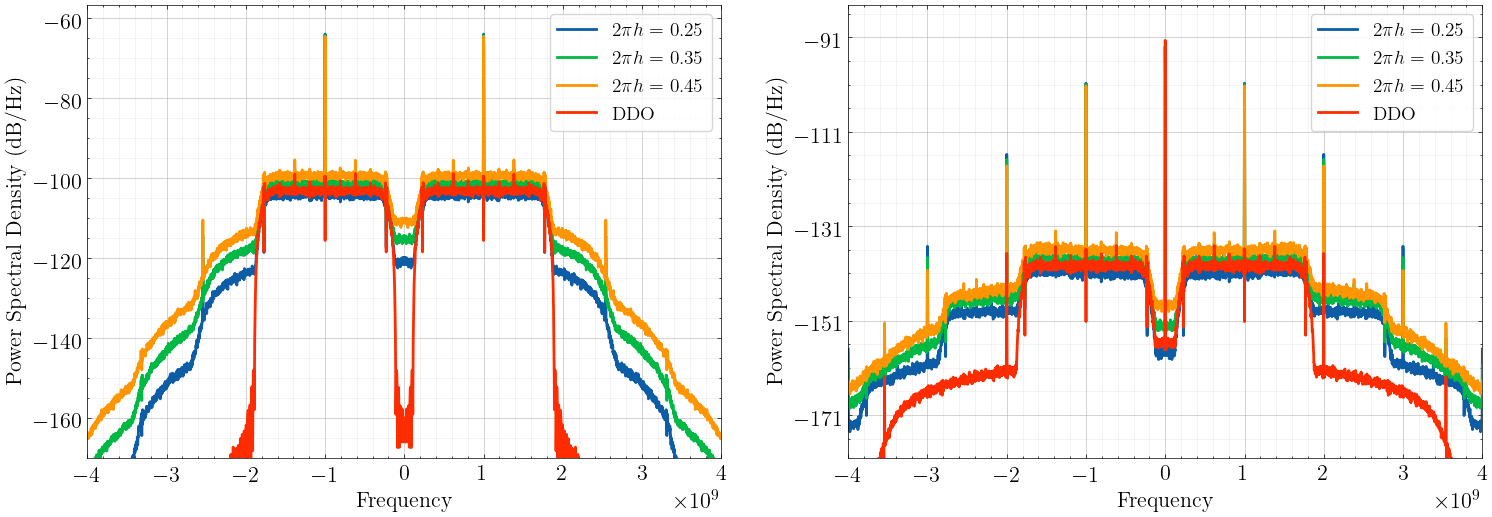

In [55]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

for i in tqdm(range(len(h))):
    paramTx.H = h[i]
    paramRx.H = paramTx.H
    
    for ind, osnr in enumerate(OSNR):     
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        if(ind == 0):
            ax[0].psd(sigTx_CE, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"$2\pi h =$ {round(2*pi*h[i],2)}")
            ax[0].legend(frameon = True)
            ax[0].set_xlim(-4e9, 4e9)
            ax[0].legend(frameon = True, fontsize = 14)
            
            ax[1].psd(sigTxo, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"$2\pi h =$ {round(2*pi*h[i],2)}")
            ax[1].legend(frameon = True)
            ax[1].set_xlim(-4e9, 4e9)
            ax[1].legend(frameon = True, fontsize = 14)
        
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # optical filter
        filtro_optico_CEDD = lowPassFIR(B[i], paramTx.Fa, 8001, typeF='rect')

        # optical filter
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)

        ipd = photodiode(sigRxo, paramPD)
        
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_CEDD_B2B[i, ind], _, SNR_CEDD_B2B[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')       

        if ind == len(OSNR)-1:
            sigTxoCEDD = sigTxo.copy()


filtro_optico_DD = lowPassFIR(1.9e9, paramTx.Fa, 8001, typeF='rect')
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
for ind, osnr in enumerate(OSNR):     
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    if(ind == 0):
        ax[0].psd(sigTx_DD, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = "DDO")
        ax[0].legend(frameon = True)
        ax[0].set_xlim(-4e9, 4e9)
        ax[0].legend(frameon = True, fontsize = 14)
            
        ax[1].psd(sigTxo, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = "DDO")
        ax[1].legend(frameon = True)
        ax[1].set_xlim(-4e9, 4e9)
        ax[1].legend(frameon = True, fontsize = 14)
    
    snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))
    sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
    # optical filter
    sigRxo = firFilter(filtro_optico_DD, sigRxo)
        
    ipd = photodiode(sigRxo, paramPD)
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

    BER_DD_B2B[ind], _, SNR_DD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam') 
    
    if ind == len(OSNR)-1:
        sigTxoDD = sigTxo.copy()
        
ax[0].set_ylim(-170)
ax[1].set_ylim(-180)
ax[0].grid(which='minor', alpha=0.2)
ax[0].grid(which='major', alpha=0.8)
ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


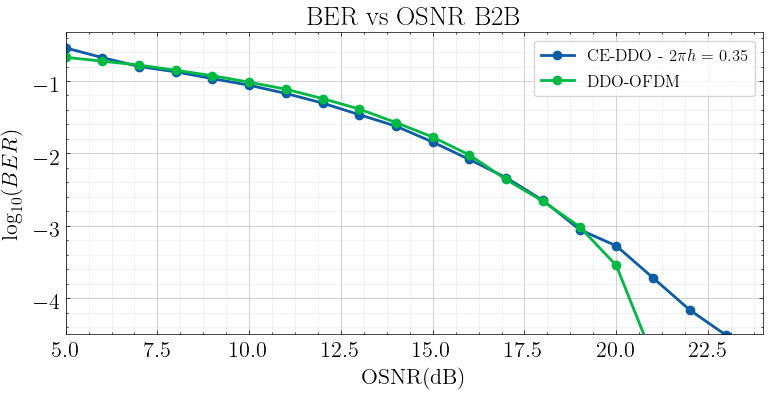

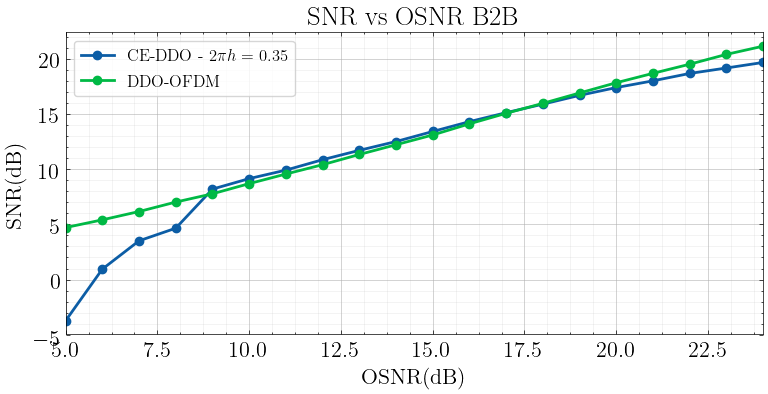

In [59]:
plt.figure(figsize = (9, 4))

plt.plot(OSNR, np.log10(BER_CEDD_B2B[1,:]), '-o', ms = 6, lw = 2, label = f'CE-DDO - $2\pi h = $ {round(2*pi*h[1], 2)}') 
plt.plot(OSNR, np.log10(BER_DD_B2B), '-o', ms = 6, lw = 2, label = f'DDO-OFDM')
plt.title("BER vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-4.5)
plt.legend(fontsize = 12, frameon = True)
plt.xlim(min(OSNR), max(OSNR))
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (9, 4))

plt.plot(OSNR, SNR_CEDD_B2B[1,:], '-o', ms = 6, lw = 2, label = f'CE-DDO - $2\pi h = $ {round(2*pi*h[1], 2)}')
plt.plot(OSNR, SNR_DD_B2B, '-o', ms = 6, lw = 2, label = f'DDO-OFDM')

plt.title("SNR vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"SNR(dB)")
plt.legend(fontsize = 12, frameon = True)
plt.xlim(min(OSNR), max(OSNR))
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


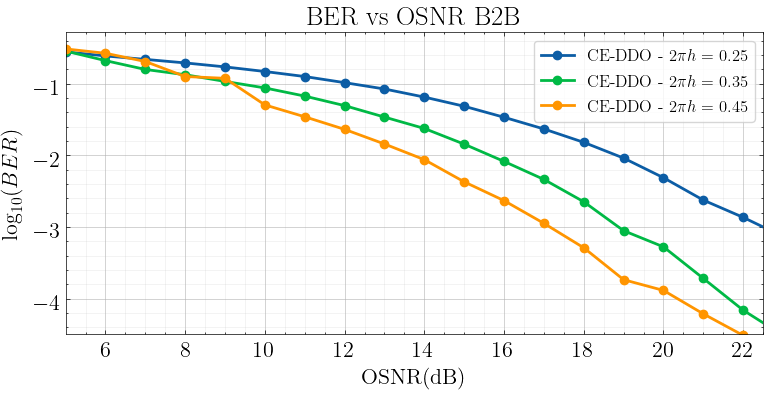

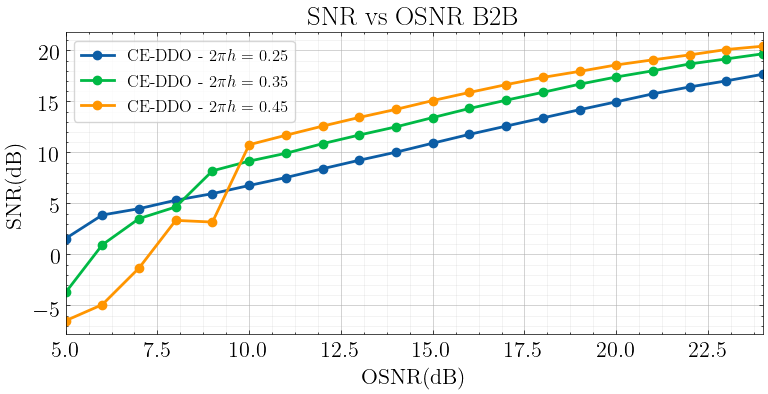

In [57]:
plt.figure(figsize = (9, 4))

for i in range(len(h)):
    plt.plot(OSNR, np.log10(BER_CEDD_B2B[i,:]), '-o', ms = 6, lw = 2, label = f'CE-DDO - $2\pi h = $ {round(2*pi*h[i], 2)}')

plt.title("BER vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-4.5)
plt.legend(fontsize = 12, frameon = True)
plt.xlim(min(OSNR), 22.5)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (9, 4))

for i in range(len(h)):
    plt.plot(OSNR, SNR_CEDD_B2B[i,:], '-o', ms = 6, lw = 2, label = f'CE-DDO - $2\pi h = $ {round(2*pi*h[i], 2)}')

plt.title("SNR vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"SNR(dB)")
plt.legend(fontsize = 12, frameon = True)
plt.xlim(min(OSNR), max(OSNR))
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)